In [1]:
import numpy as np
import pandas as pd
# from sklearn.preprocessing import
from sklearn.model_selection import train_test_split
from random import randint
import sklearn.metrics as skm
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

In [2]:
def replace_rare_entries(df, columns, threshold_frac):
    tot_instances = df.shape[0]
    threshold = tot_instances * threshold_frac
    df = df.apply(lambda x: x.mask(x.map(x.value_counts()) < threshold, 'RARE') if x.name in columns else x)
    return df
    

In [21]:
categoricals = ['OP_UNIQUE_CARRIER', 'DEST', 'DEP_TIME_BLK', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'MONTH']
targets = ['DEP_DELAY_NEW', 'DEP_DEL15']

In [22]:
df = pd.read_csv('/home/dbeiski/Project/FlightDelay/Data/new_york/year_lga_dep.csv')

In [23]:
data = df.drop([col for col in df.columns if col not in categoricals], axis=1)
data = replace_rare_entries(data, ['DEST'], 0.005)
data = replace_rare_entries(data, ['UNIQUE_CARRIER'], 0.005)
data = pd.get_dummies(data, columns=categoricals)
label = df['DEP_DEL15']

In [24]:
data.columns

Index(['OP_UNIQUE_CARRIER_9E', 'OP_UNIQUE_CARRIER_AA', 'OP_UNIQUE_CARRIER_B6',
       'OP_UNIQUE_CARRIER_DL', 'OP_UNIQUE_CARRIER_EV', 'OP_UNIQUE_CARRIER_F9',
       'OP_UNIQUE_CARRIER_MQ', 'OP_UNIQUE_CARRIER_NK', 'OP_UNIQUE_CARRIER_OH',
       'OP_UNIQUE_CARRIER_OO',
       ...
       'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8',
       'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12'],
      dtype='object', length=135)

In [25]:
data = data[~label.isna()]
label = label[~label.isna()]

In [26]:
print('Rows: {}\nFeatures: {}\nLabel-1 Fraction: {}'
      .format(data.shape[0], data.shape[1], label.sum() / label.shape[0]))

Rows: 181088
Features: 135
Label-1 Fraction: 0.21473537727513695


In [27]:
thres = np.linspace(0, 1, 500)

In [28]:
x, x_test, y, y_test = train_test_split(data, label, test_size=0.2, 
                                                        random_state=randint(1, 500),
                                                        stratify=label)

In [29]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, 
                                                        random_state=randint(1, 500),
                                                        stratify=y)
Dtrain = xgb.DMatrix(x_train, label=y_train)
Dval = xgb.DMatrix(x_val, label=y_val)

/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [30]:
y_train.shape[0]

115896

In [31]:
param = {                              # General guidelines for initial paramaters:
    'min_child_weight': 1,             # 1 (choose small for high class imbalance)
    'gamma': 0.3,                        # 0.1-0.2
    'lambda': 0,  #1                     # L2 Regulariztion - default = 1
    'scale_pos_weight': 4,             # 1 (choose small for high class imbalance)
    'subsample': 0.6,                    # 0.5-0.9
    'colsample_bytree': 0.8,             # 0.5-0.9
    'colsample_bylevel': 0.7,              # 0.5-0.9
    'max_depth': 6,  #5                  # 3-10 
    'eta': 0.1,                        # 0.05-0.3
    'silent': 0,                       # 0 - prints progress    1 - quiet
    'objective': 'binary:logistic',        
    'num_class': 1,             
    'eval_metric': 'auc'}  
num_round = 10000                                      # the number of training iterations if not stopped early
evallist = [(Dtrain, 'train'), (Dval, 'eval')]        # Specify validation set to watch performance

In [32]:
# Train the model on the training set to get an initial impression on the performance
model = xgb.train(param, Dtrain, num_round, evallist, early_stopping_rounds=10)
print("Best error: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	train-auc:0.621038	eval-auc:0.616173
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.658771	eval-auc:0.654173
[2]	train-auc:0.670372	eval-auc:0.663889
[3]	train-auc:0.675458	eval-auc:0.666975
[4]	train-auc:0.677271	eval-auc:0.669582
[5]	train-auc:0.679153	eval-auc:0.671813
[6]	train-auc:0.686922	eval-auc:0.680025
[7]	train-auc:0.690816	eval-auc:0.684448
[8]	train-auc:0.693169	eval-auc:0.686629
[9]	train-auc:0.697013	eval-auc:0.689789
[10]	train-auc:0.699125	eval-auc:0.69269
[11]	train-auc:0.703436	eval-auc:0.695803
[12]	train-auc:0.706726	eval-auc:0.699436
[13]	train-auc:0.7066	eval-auc:0.699369
[14]	train-auc:0.709893	eval-auc:0.701693
[15]	train-auc:0.713327	eval-auc:0.704496
[16]	train-auc:0.714491	eval-auc:0.705613
[17]	train-auc:0.715084	eval-auc:0.706284
[18]	train-auc:0.715888	eval-auc:0.706921
[19]	train-auc:0.719101	eval-auc:0.709335
[20]	train-auc:0.722355	eval-auc

[191]	train-auc:0.816689	eval-auc:0.784167
[192]	train-auc:0.816862	eval-auc:0.784325
[193]	train-auc:0.817074	eval-auc:0.784417
[194]	train-auc:0.817168	eval-auc:0.78444
[195]	train-auc:0.817326	eval-auc:0.784393
[196]	train-auc:0.817517	eval-auc:0.784562
[197]	train-auc:0.817589	eval-auc:0.78463
[198]	train-auc:0.817754	eval-auc:0.784799
[199]	train-auc:0.818083	eval-auc:0.785103
[200]	train-auc:0.818247	eval-auc:0.78512
[201]	train-auc:0.81849	eval-auc:0.78538
[202]	train-auc:0.81859	eval-auc:0.785364
[203]	train-auc:0.818928	eval-auc:0.785629
[204]	train-auc:0.81911	eval-auc:0.785805
[205]	train-auc:0.81935	eval-auc:0.78591
[206]	train-auc:0.819381	eval-auc:0.785942
[207]	train-auc:0.819459	eval-auc:0.785853
[208]	train-auc:0.819636	eval-auc:0.786033
[209]	train-auc:0.819749	eval-auc:0.786032
[210]	train-auc:0.819962	eval-auc:0.786118
[211]	train-auc:0.820168	eval-auc:0.786198
[212]	train-auc:0.820242	eval-auc:0.786181
[213]	train-auc:0.820391	eval-auc:0.786153
[214]	train-auc:0.82

[383]	train-auc:0.844589	eval-auc:0.793551
[384]	train-auc:0.844682	eval-auc:0.793573
[385]	train-auc:0.844814	eval-auc:0.793687
[386]	train-auc:0.84492	eval-auc:0.793629
[387]	train-auc:0.845031	eval-auc:0.793579
[388]	train-auc:0.845099	eval-auc:0.793619
[389]	train-auc:0.845218	eval-auc:0.793617
[390]	train-auc:0.845341	eval-auc:0.793634
[391]	train-auc:0.845488	eval-auc:0.793742
[392]	train-auc:0.845553	eval-auc:0.793762
[393]	train-auc:0.845675	eval-auc:0.793762
[394]	train-auc:0.845806	eval-auc:0.793823
[395]	train-auc:0.845958	eval-auc:0.793823
[396]	train-auc:0.84604	eval-auc:0.793822
[397]	train-auc:0.846155	eval-auc:0.79378
[398]	train-auc:0.846313	eval-auc:0.793847
[399]	train-auc:0.846404	eval-auc:0.793852
[400]	train-auc:0.846452	eval-auc:0.793788
[401]	train-auc:0.846545	eval-auc:0.793776
[402]	train-auc:0.846718	eval-auc:0.793846
[403]	train-auc:0.846805	eval-auc:0.793894
[404]	train-auc:0.846893	eval-auc:0.7939
[405]	train-auc:0.847032	eval-auc:0.793918
[406]	train-auc:

In [33]:
Dtest = xgb.DMatrix(x_test, label=y_test)
probas = model.predict(Dtest)
y_test = Dtest.get_label()

/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


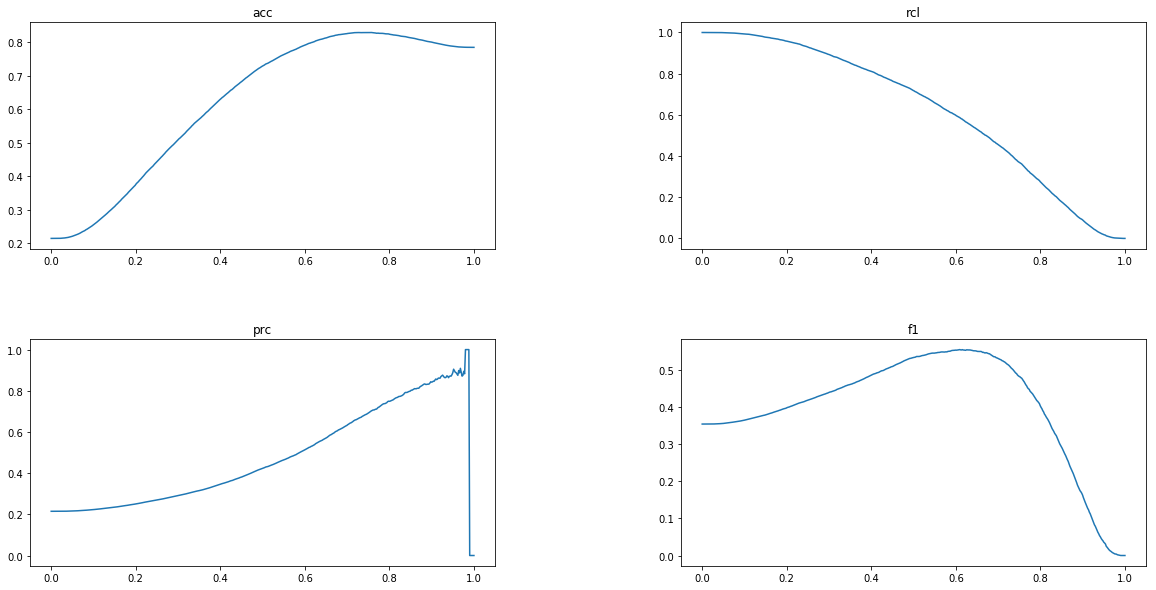

In [34]:
accs, recalls, precs, f1s = [], [], [], []
for thr in thres:
    y_pred = (probas > thr).astype(int)
    accs.append(skm.accuracy_score(y_test, y_pred))
    recalls.append(skm.recall_score(y_test, y_pred))
    precs.append(skm.precision_score(y_test, y_pred))
    f1s.append(skm.f1_score(y_test, y_pred))
    
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, (metric, name) in enumerate(zip([accs, recalls, precs, f1s], ['acc', 'rcl', 'prc', 'f1']), start=1):
    fig.add_subplot(2, 2, i)
    plt.plot(thres, metric)
    plt.title(name)


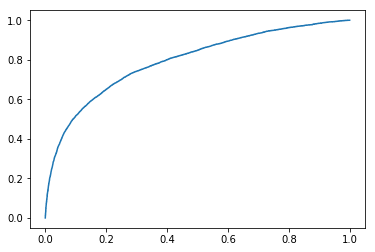

In [35]:
tpr, fpr, _ = roc_curve(y_test, probas)
plt.plot(tpr, fpr);

In [36]:
best_thres = thres[np.argmax(f1s)]
y_pred = (probas > best_thres).astype(int)
print('Acc for max f1 threshold: ', skm.accuracy_score(y_test, y_pred))
print('Max acc : ', max(accs))
print('Recall : ', skm.recall_score(y_test, y_pred))

Acc for max f1 threshold:  0.7969794025070407
Max acc :  0.8296427190899552
Recall :  0.5867301015815868


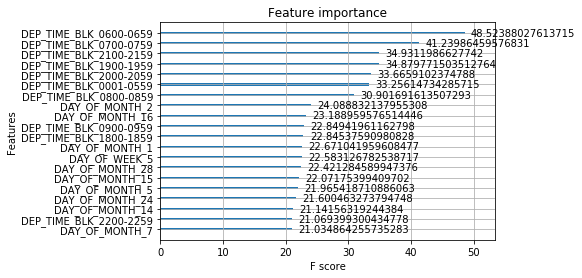

In [37]:
xgb.plot_importance(model, max_num_features=20, importance_type='gain');